In [1]:
import sys, os, time
import shutil
# %pdb
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision

from contextlib import nullcontext, redirect_stdout, redirect_stderr

from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
# plt.switch_backend('Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from bisect import bisect_left

# from IPython.display import HTML, Image

#from foundation.util import replicate, Cloner

from analyze import *

import evaluate as dis_eval
from hybrid import get_model, get_data

from run_fid import compute_inception_stat, load_inception_model, compute_frechet_distance

from tqdm import tqdm_notebook as tqdm

plt.ioff()

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
M = Hybrid_Controller().filter_strs('!test')

Found 331 runs
Auto parsing failed with: test-cmd_200202-182019
Auto parsing failed with: test-cmd_200202-182140
Auto parsing failed with: test-cmd_200202-182804
Auto parsing failed with: test-cmd_200202-183508
Auto parsing failed with: test-cmd_200202-192959
Auto parsing failed with: test-cmd_200202-194400
Auto parsing failed with: test-cmd_200202-200904
Auto parsing failed with: test-cmd_200202-201315
Auto parsing failed with: test-cmd_200202-203736
Auto parsing failed with: test-cmd_200203-120137
Auto parsing failed with: test-cmd_200203-121144
Auto parsing failed with: test-cmd_200203-121301
Auto parsing failed with: test-cmd_200203-204121
Auto parsing failed with: test-cmd_200213-130841
Auto parsing failed with: test-cmd_200213-132715
Auto parsing failed with: test-cmd_200213-133520
Auto parsing failed with: test-pycharm_200202-162713
Auto parsing failed with: test-pycharm_200202-162914
Auto parsing failed with: test-pycharm_200202-164740
Auto parsing failed with: test-pycharm_200

In [3]:
# M.clear_filters().filter_strs('!test').filter_jobs(167, 168).show_incomplete()

In [4]:
M.clear_run_cache()

In [29]:
M.clear_filters().filter_strs('!test')

final_jobs = {
#     'box-s3': {'ae':'74-0', 'wae':'74-1', 'vae':'74-2', 'bvae':'74-3', 'fae':'74-4', 'fwae':'74-5', 
#                'fvae':'74-6', 'dae':'79-1', },
#     'nocap2cap': {'ae':'86-0', 'wae':'86-1', 'vae':'86-2', 'bvae':'86-3', 'fae':'99-0', 'dae':'99-1', 
#                   'fwae':'86-4', 'fvae':'86-5', },
#     'spaceinv': {'wae':'64-1', '4vae':'64-3', 'fwae':'64-5', 'fvae':'64-7', 'ae':'64-0', 'vae':'64-2', 
#                  '16vae':'64-4', 'fwaes':'64-6', 'fdwaes':'64-11', 'fdwae':'64-10', 'dvae':'64-8', 'dwae':'64-9'},
    '3dshapes': {'ae':'30-0','wae':'28-1', 'vae':'28-2', 'bvae':'28-3', 'fae':'31-0', 'dae':'30-2', 
                 'fwae':'28-5', 'fvae':'29-6'},
#     '3dshapes-adain': {'ae':'35-2','wae':'35-3','vae':'35-4','bvae':'35-5','dae':'35-6','fwae':'35-7','fvae':'35-8'},
#     'celeba': {'ae':'51-0','wae':'51-1','vae':'51-2','4vae':'51-3','16vae':'51-4','fwae':'51-5',
#                'fwaes':'51-6', 'fvae':'51-7', 'dae':'103-1', 'fae':'103-0', 'dwae':'51-9', 
#                'fdwae.1':'51-11'},
#     'celeba-adain': {'ae':'55-0', 'wae':'55-1', 'fwae':'55-5', 'fwaes':'55-6'},
#     'mpi-toy': {'ae':'58-0','wae':'58-1','vae':'58-2', '4vae':'58-3', '16vae':'58-4', 
#                 'fwae':'58-5', 'fwaes':'58-6', 'fdwae':'58-10', 'dvae':'58-8'},
#     'mpi-toy-adain': {'ae':'80-0', 'wae':'80-1', 'vae':'80-2', '4vae':'80-3', '16vae':'80-4', 'fwae':'80-5', 
#                       'fvae':'80-7', },# '80-10'
#     'mpi-real': {'ae':'72-0', 'wae':'72-1', 'vae':'72-2', '4vae':'72-3', '16vae':'72-4', 'fwae':'72-5', 
#                  'fwaes':'72-6', 'fvae':'72-7'},
#     'mpi-realistic': { 'wae':'78-1', 'vae':'78-2', '4vae':'78-3', '16vae':'78-4', 'fwae':'78-5', 
#                       'fwaes':'78-6', 'fvae':'78-7'},# '78-0',
    
#     'arch': {'reg':'30-0', 's2-d4':'35-2', 's3-d0':'88-0', 's1-d8':'88-1', 's2-d4(2)':'88-2', 
#              's1-d0':'88-3', 's1-d2':'88-4'},
    
#     'box': {'ae':'45-0',  'wae':'45-1', 'vae':'45-2', '4vae':'45-3', 'fae':'45-4', 'dae':'45-5', 
#             'fwae':'45-6', 'fvae':'45-7'},
#     'box-s1': {'ae':'47-1', 'wae':'47-2', 'vae':'47-3', '4vae':'47-4', 'fae':'47-5', 'dae':'67-0', 
#                'fwae':'47-6', 'fvae':'47-7'},
#     'box-s2': {'ae':'60-0', 'wae':'60-1', 'vae':'60-2', '4vae':'60-3', 'fae':'60-4',  'dae':'76-0', 
#                'fwae':'60-5', 'fvae':'60-6'},
    
#     'nocap': {'ae':'71-0', 'wae':'71-1', 'vae':'71-2', '4vae':'71-3', 'fae':'71-4', 'dae':'71-5', 
#               'fwae':'71-6', 'fvae':'71-7'},
    
#     'pacman': {'ae':'96-0', 'wae':'96-1', 'vae':'96-2', '16vae':'96-4','fwae':'96-5', 'fwaes':'96-6', 
#                'dvae':'96-8', 'dwae':'96-9', 'fdwae':'96-10', 'fdwae.1':'96-11'},
    
    
}

allowed = sum([list(v.values()) for v in final_jobs.values()],[])
print(len(allowed))

M.filter_jobs(*allowed)
allowed = set(allowed)
print(len(allowed))

# M.filter_jobs(47)

# M.filter_jobs(78)
# M.filter_models('ae')
# M.filter_datasets('3dshapes')
# M.filter(lambda r: 'n/adain-dec' in r.config.info.history or 'n/adain-large' in r.config.info.history)
# M.filter_models('wgan')

# M.filter_datasets('nocap')
# M.filter_datasets('mpi3d')
# M.filter_datasets('3dshapes')

M.prep_info()
# M.filter_min(ckpt=30)

# M.filter_checkpoints(60)

# M.load_configs(60)

# M.load_configs(100)

M.sort_by('date').sort_by('job')
pass
M.show()


8
8
Selecting checkpoint: last
Loaded configs
  0) 3dshapes-wae_0028-6046939-01_200131-124832
  1) 3dshapes-vae_0028-6046939-02_200131-124807
  2) 3dshapes-vae_0028-6046939-03_200131-124821
  3) 3dshapes-fwae_0028-6046939-05_200131-124815
  4) 3dshapes-fvae_0029-6046947-06_200131-125026
  5) 3dshapes-ae_0030-6046949-00_200131-125923
  6) 3dshapes-dae_0030-6046949-02_200131-125904
  7) 3dshapes-fae_0031-6046954-00_200131-132552


In [30]:
for r in M:
    tag = '{}-{}'.format(r.meta.job[0],r.meta.job[2],)
    allowed.discard(tag)
allowed

set()

In [7]:
# M.prep_info(100)
M.prep_info()
# M.load_records(tqdm)

Selecting checkpoint: last
Loaded configs


In [8]:
M.show('ckpt')

  0) 3dshapes-wae_0028-6046939-01_200131-124832
	Checkpoint: 30 (approx 150000 steps)

  1) 3dshapes-vae_0028-6046939-02_200131-124807
	Checkpoint: 30 (approx 150000 steps)

  2) 3dshapes-vae_0028-6046939-03_200131-124821
	Checkpoint: 30 (approx 150000 steps)

  3) 3dshapes-fwae_0028-6046939-05_200131-124815
	Checkpoint: 30 (approx 150000 steps)

  4) 3dshapes-fvae_0029-6046947-06_200131-125026
	Checkpoint: 30 (approx 150000 steps)

  5) 3dshapes-ae_0030-6046949-00_200131-125923
	Checkpoint: 30 (approx 150000 steps)

  6) 3dshapes-dae_0030-6046949-02_200131-125904
	Checkpoint: 30 (approx 150000 steps)

  7) 3dshapes-fae_0031-6046954-00_200131-132552
	Checkpoint: 30 (approx 150000 steps)



In [9]:
M.clear_run_cache()

In [10]:
# M[0].ckpt_path

In [11]:
# M.sort_by('job')
# print('\n'.join('unbuffer python main_eval.py --legacy 0 --resume {}'.format(n) for n in M.through().name))
# print('\n'.join('unbuffer python main_eval.py --names {} --save-dir /home/fleeb/results/test'.format(n) for n in M.through().name))
# print('\n'.join('unbuffer python main_eval.py --names {} --save-dir /home/fleeb/results/test'.format(n) for n in M.through().name))
# tmpl= 'unbuffer python hybrid.py n/t/nocap2cap --load {}'#' --model.lr 5e-4'
tmpl= 'unbuffer python hybrid.py --legacy 0 --resume {}'
tmpl = 'unbuffer python main_eval_final.py {} /home/fleeb/results/final'

print('\n'.join(tmpl.format(n) for n in M.through().name))

unbuffer python main_eval_final.py 3dshapes-wae_0028-6046939-01_200131-124832 /home/fleeb/results/final
unbuffer python main_eval_final.py 3dshapes-vae_0028-6046939-02_200131-124807 /home/fleeb/results/final
unbuffer python main_eval_final.py 3dshapes-vae_0028-6046939-03_200131-124821 /home/fleeb/results/final
unbuffer python main_eval_final.py 3dshapes-fwae_0028-6046939-05_200131-124815 /home/fleeb/results/final
unbuffer python main_eval_final.py 3dshapes-fvae_0029-6046947-06_200131-125026 /home/fleeb/results/final
unbuffer python main_eval_final.py 3dshapes-ae_0030-6046949-00_200131-125923 /home/fleeb/results/final
unbuffer python main_eval_final.py 3dshapes-dae_0030-6046949-02_200131-125904 /home/fleeb/results/final
unbuffer python main_eval_final.py 3dshapes-fae_0031-6046954-00_200131-132552 /home/fleeb/results/final


In [7]:
A = '''unbuffer python main_eval_final.py celeba-fae_0103-6052317-00_200203-204149 /home/fleeb/results/final
unbuffer python main_eval_final.py celeba-dae_0103-6052317-01_200203-204150 /home/fleeb/results/final
unbuffer python main_eval_final.py celeba-fdwae_0051-6050322-11_200201-212849 /home/fleeb/results/final
unbuffer python main_eval_final.py celeba-dwae_0051-6050322-09_200201-212721 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-ae_0064-6050849-00_200202-183950 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-fdwae_0064-6050849-10_200202-190944 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-fdwae_0064-6050849-11_200202-190944 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-vae_0064-6050849-02_200202-190121 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-vae_0064-6050849-04_200202-190736 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-fwae_0064-6050849-06_200202-191020 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-dvae_0064-6050849-08_200202-190947 /home/fleeb/results/final
unbuffer python main_eval_final.py spaceinv-dwae_0064-6050849-09_200202-190951 /home/fleeb/results/final'''.split('\n')

In [9]:
fl = ['chome/results/final/' + a.split(' ')[-2] + '_*' for a in A]
' '.join(fl)

'chome/results/final/celeba-fae_0103-6052317-00_200203-204149_* chome/results/final/celeba-dae_0103-6052317-01_200203-204150_* chome/results/final/celeba-fdwae_0051-6050322-11_200201-212849_* chome/results/final/celeba-dwae_0051-6050322-09_200201-212721_* chome/results/final/spaceinv-ae_0064-6050849-00_200202-183950_* chome/results/final/spaceinv-fdwae_0064-6050849-10_200202-190944_* chome/results/final/spaceinv-fdwae_0064-6050849-11_200202-190944_* chome/results/final/spaceinv-vae_0064-6050849-02_200202-190121_* chome/results/final/spaceinv-vae_0064-6050849-04_200202-190736_* chome/results/final/spaceinv-fwae_0064-6050849-06_200202-191020_* chome/results/final/spaceinv-dvae_0064-6050849-08_200202-190947_* chome/results/final/spaceinv-dwae_0064-6050849-09_200202-190951_*'

In [37]:
run = M[-2]
run.name

'3dshapes-dae_0030-6046949-02_200131-125904'

In [38]:
run.meta.dataset

'3dshapes'

In [39]:
M.clear_run_cache()

In [40]:
def gen_prior(model, N):
    return model.generate(N)

def gen_target(model, X=None, Q=None, hybrid=False, ret_q=False):
    
    if Q is None:
        assert X is not None
        
        Q = model.encode(X)
        if isinstance(Q, distrib.Distribution):
            Q = Q.mean
            
    if hybrid:
        Q = util.shuffle_dim(Q)
        
    gen = model.decode(Q)
    
    if ret_q:
        return gen, Q
    return gen

def _new_loader(dataset, batch_size, shuffle=False):
    return trn.get_loaders(dataset, batch_size=batch_size, shuffle=shuffle)
def gen_batch(dataset, N=None, loader=None, shuffle=False, seed=None, ret_loader=False):
    
    if seed is not None:
        util.set_seed(seed)
    
    if loader is None:
        assert N is not None
        loader = iter(_new_loader(dataset, batch_size=N, shuffle=shuffle))
        
    try:
        batch = util.to(next(loader), 'cuda')
        B = batch.size(0)
    except StopIteration:
        pass
    else:
        if N is None or B == N:
            if ret_loader:
                return batch[0], loader
            return batch[0]
    
    
    loader = iter(_new_loader(dataset, batch_size=N, shuffle=shuffle))
    batch = util.to(next(loader), 'cuda')
    
    if ret_loader:
        return batch[0], loader
    
    return batch[0]
    
def compute_all_fid_scores(model, dataset, fid_stats_ref_path, fid=None):
    
    if fid is None:
        fid = {'scores':{}, 'stats':{}}
    
    path = os.path.join(os.environ["FOUNDATION_DATA_DIR"], fid_stats_ref_path)
    f = pickle.load(open(path, 'rb'))
    ref_stats = f['m'][:], f['sigma'][:]
    
    inception = load_inception_model(dim=2048, device='cuda')
    
    # rec
    name = 'rec'
    if name not in fid['scores']:
        util.set_seed(0)
        loader = None
        def _generate(N):
            nonlocal loader
            X, loader = gen_batch(dataset, loader=loader, shuffle=True, N=N, ret_loader=True)
            return gen_target(model, X=X, hybrid=False)

        stats = compute_inception_stat(_generate, inception=inception, pbar=tqdm, n_samples=100) # TESTING

        fid['scores'][name] = compute_frechet_distance(*stats, *ref_stats)
        fid['stats'][name] = stats
    print('FID-rec: {:.2f}'.format(fid['scores'][name]))
    
    # hyb
    name = 'hyb'
    if name not in fid['scores']:
        util.set_seed(0)
        loader = None
        def _generate(N):
            nonlocal loader
            X, loader = gen_batch(dataset, loader=loader, shuffle=True, N=N, ret_loader=True)
            return gen_target(model, X=X, hybrid=True)

        stats = compute_inception_stat(_generate, inception=inception, pbar=tqdm, n_samples=100) # TESTING

        fid['scores'][name] = compute_frechet_distance(*stats, *ref_stats)
        fid['stats'][name] = stats
    print('FID-hybrid: {:.2f}'.format(fid['scores'][name]))
    
    # prior
    name = 'prior'
    if name not in fid['scores']:
        util.set_seed(0)
        def _generate(N):
            return gen_prior(model, N)

        stats = compute_inception_stat(_generate, inception=inception, pbar=tqdm, n_samples=100) # TESTING

        fid['scores'][name] = compute_frechet_distance(*stats, *ref_stats)
        fid['stats'][name] = stats
    print('FID-prior: {:.2f}'.format(fid['scores'][name]))
    
    return fid

_disent_eval_fns = {
    'IRS': dis_eval.eval_irs, # TESTING
#     'MIG': dis_eval.eval_mig,
#     'DCI': dis_eval.eval_dci,
#     'SAP': dis_eval.eval_sap,
#     'ModExp': dis_eval.eval_modularity_explicitness,
#     'Unsup': dis_eval.eval_unsupervised,
    
#     'bVAE': dis_eval.eval_beta_vae,
#     'FVAE': dis_eval.eval_factor_vae,
}

def compute_all_disentanglement(model, disent=None):
    
    if disent is None:
        disent = {}
        
    dataset = dis_eval.shapes3d.Shapes3D()
    repr_fn = dis_eval.representation_func(model, 'cuda')
        
    itr = tqdm(_disent_eval_fns.items(), total=len(_disent_eval_fns))
        
    for name, eval_fn in itr:
        itr.set_description(name)
        if name not in disent:
            disent[name] = eval_fn(model='', representation_function=repr_fn, dataset=dataset, seed=0)
        print('{}: {}'.format(name, disent[name]))
    
    return disent


In [41]:
save_dir = '/is/ei/fleeb/workspace/media/hybrid/post/final/'

In [42]:
# def _full_analyze(run):

S = run.reset()

dname = run.meta.dataset

if 'box' in dname:
    dname = '3dshapes'

# check for existing results

save_path = os.path.join(save_dir, run.name)
util.create_dir(save_path)

results_path = os.path.join(save_path, 'results.pth.tar')
evals_path = os.path.join(save_path, 'evals.pth.tar')

if os.path.isfile(results_path):
    print('Found existing results: {}'.format(results_path))
    results = torch.load(results_path)
    print(results.keys())
else:
    results = {}

if os.path.isfile(evals_path):
    print('Found existing evals: {}'.format(evals_path))
    evals = torch.load(evals_path)
    print(evals.keys())
else:
    evals = {}


# check for completion
if 'fid' in results and ('disent' in results or dname != '3dshapes') and 'H' in results:
    print('Skipping {}, all analysis is already done'.format(run.name))
    raise Exception() # testing
#     return

# build dataset


print('loading dataset {} for {}'.format(run.meta.dataset, run.name))



eval_disentanglement_metrics = dname == '3dshapes'

if dname == '3dshapes':

    C = trn.get_config('n/3dshapes')    
    fid_stats_ref_path = '3dshapes/3dshapes_stats_fid.pkl'
#     batch_size = 128

    pass
elif dname in 'celeba':
    C = trn.get_config('n/celeba')
    fid_stats_ref_path = 'celeba/celeba_stats_fid.pkl'
    fid_stats = ''
#     batch_size = 32
elif dname == 'atari':
    C = trn.get_config('n/atari')
#     batch_size = 32

    C.dataset.game = run.config.dataset.game
    print('using {} game'.format(C.dataset.game))
    fid_stats_ref_path = 'fid_stats/{}_fid_stats.pkl'.format(C.dataset.game)
    # get game

elif dname == 'mpi3d':
    C = trn.get_config('n/mpi3d')


    C.dataset.category = run.config.dataset.category
    print('using {} cat'.format(C.dataset.category))
    fid_stats_ref_path = 'mpi3d/mpi3d_{}_stats_fid.pkl'.format(C.dataset.category)

#     batch_size = 128

    # get category

else:
    raise Exception('{} not found'.format(dname))

batch_size = 128

C.dataset.device = 'cpu'

C.dataset.train = False

if 'val_split' in C.dataset:
    del C.dataset.val_split

print('loading model {}'.format(run.ckpt_path))

S.A = trn.get_config()

if run.meta.dataset in {'celeba', 'atari'}:
    din, dout = (3,128,128),(3,128,128)
else:
    din, dout = (3,64,64), (3,64,64)

S.A.din, S.A.dout = din, dout

with redirect_stdout(open('/dev/null', 'w')):
    run.load(fast=True)
#     run.load(fast=True)

model = S.model

print('model loaded')

loading dataset 3dshapes for 3dshapes-dae_0030-6046949-02_200131-125904
loading model /is/ei/fleeb/workspace/chome/trained_nets/3dshapes-dae_0030-6046949-02_200131-125904/checkpoint_30.pth.tar
model loaded


In [43]:
model

Dropin_WPP(
  (enc): Double_Encoder(
    (layers): ModuleList(
      (0): DoubleConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        (nonlin): ELU(alpha=1.0, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
        (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (out_nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): DoubleConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
        (nonlin): ELU(alpha=1.0, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
        (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (out_nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): DoubleConvLayer(
  

In [45]:
model.optim

Complex_Optimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.5, 0.9)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [17]:


if dname == '3dshapes': # disentanglement metrics

    if 'disent' not in results:
        results['disent'] = {}

    print('Computing Disentanglement metrics')

    results['disent'] = compute_all_disentanglement(model, disent=results['disent'])
    torch.save(results, results_path)
    print('Saved results to {}'.format(results_path))
    evals['disent'] = results['disent']


datasets, = trn.load(A=C, get_data=get_data, get_model=None, mode='test')
dataset = datasets[0]

S.dataset = dataset
S.dname = dname

S.batch_size = batch_size

print('dataset {} loaded: {}'.format(run.meta.dataset, len(dataset)))


dataroot: /is/ei/fleeb/workspace/local_data
train: False
labeled: False (by default)
din: (3, 64, 64) (by default)
dout: (3, 64, 64) (by default)
category: real
Dataset moved to cpu
dataset mpi3d loaded: 207360


In [18]:


# run


# rec error

if 'L' not in results:
    print('Computing rec loss')

    dataset = S.dataset
    batch_size = S.batch_size
    
    util.set_seed(1)
    loader = _new_loader(dataset, batch_size=batch_size, shuffle=True)

    loader = tqdm(loader)
    loader.set_description('Evaluating rec error')

    criterion = nn.BCELoss(reduction='none')

    L = []
    Q = None
    R = None
    O = None


    with torch.no_grad():

        for batch in loader:

            batch = util.to(batch, 'cuda')
            X = batch[0]
            B = X.size(0)

            rec = gen_target(model, X=X, hybrid=False, ret_q=Q is None)
            if Q is None:
                rec, Q = rec
                Q = Q.cpu()
            elif R is None:
                R = rec.cpu()
                O = X.cpu()

            loss = criterion(rec, X).view(B,-1).sum(-1)
            L.append(loss)
            
            if R is not None:
                break # TESTING

        util.set_seed(2)
        G = model.generate(len(R)).cpu()
        util.set_seed(2)
        H = gen_target(model, Q=Q.cuda(), hybrid=True).cpu()

        L = torch.cat(L)

    del loader

    results.update({
        'O':O, # original images
        'R':R, # reconstructed images
        'L':L, # reconstruction loss
        'Q':Q, # latent vectors
        'G':G, # generated samples using prior
        'H':H, # generated samples using hybridization (drop-in, prob=1)
        'key': {
            'O':'original images',
            'R': 'reconstructed images',
            'L': 'reconstruction error of each sample in the test set',
            'Q': 'latent vectors',
            'G': 'images generated from the prior',
            'H': 'images generated using hybridization (dropin, prob=1)',
        }
    })

# FID score

if 'fid' not in results:
    results['fid'] = {}
if 'scores' not in results['fid']:
    results['fid']['scores'] = {}
    results['fid']['stats'] = {}

if len(results['fid']['scores'])<3:

    print('Computing FID scores')
    
    with torch.no_grad():
        results['fid'] = compute_all_fid_scores(model, dataset, fid_stats_ref_path, fid=results['fid'])
    
    torch.save(results, results_path)
    print('Saved results to {}'.format(results_path))

if 'fid' not in evals:
    evals['fid'] = results['fid']['scores']

print('Run {} complete'.format(run.name))


run.state.evals = evals
run.state.results = results

spath = run.save(save_dir=save_dir, overwrite=True, )

run.reset()

# return results

# results = _full_analyze(run)

Computing rec loss
Using batched data loader


/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Computing FID scores


Using batched data loader

FID-rec: 61.54


Using batched data loader

FID-hybrid: 64.36



FID-prior: 63.40
Saved results to /is/ei/fleeb/workspace/media/hybrid/final/mpi3d-fwae_0072-6051169-05_200202-201938/results.pth.tar
Run mpi3d-fwae_0072-6051169-05_200202-201938 complete
Saving results to: /is/ei/fleeb/workspace/media/hybrid/final/mpi3d-fwae_0072-6051169-05_200202-201938_ckpt30
	Model saved
	Config saved
	Evaluation saved
	Results saved: O, R, L, Q, G, H, key, fid


tdict(ckpt_path)

In [19]:
spath

'/is/ei/fleeb/workspace/media/hybrid/final/mpi3d-fwae_0072-6051169-05_200202-201938_ckpt30'

In [2]:
root = '/is/ei/fleeb/workspace/chome/results/final'
name = 'spaceinv-wae_0064-6050849-01_200202-190020_ckpt40'

In [3]:
# spath = '/is/ei/fleeb/workspace/media/hybrid/final/mpi3d-fwae_0058-6050549-05_200201-230421_ckpt30'

In [4]:
results = torch.load(os.path.join(root, name, 'results.pth.tar'))
# results = torch.load(spath)
results.keys()

dict_keys(['O', 'R', 'L', 'Q', 'G', 'H', 'key', 'fid'])

In [5]:
O = results['O']
O.shape

torch.Size([128, 3, 128, 128])

<IPython.core.display.Javascript object>


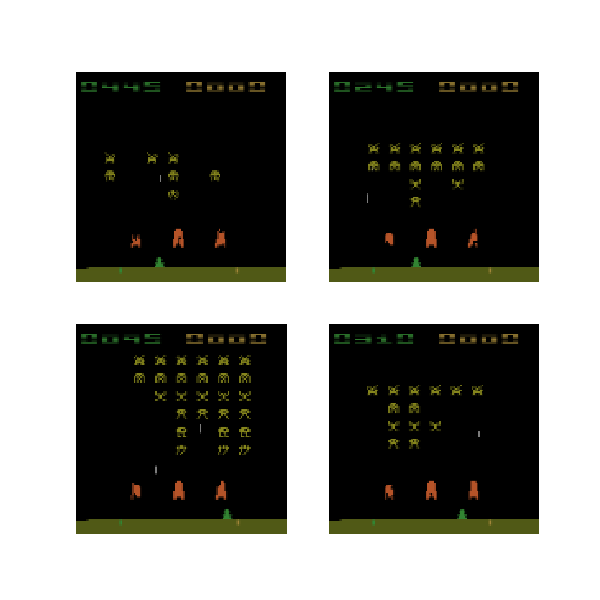

In [11]:
show_nums(results['O'][:4])

<IPython.core.display.Javascript object>


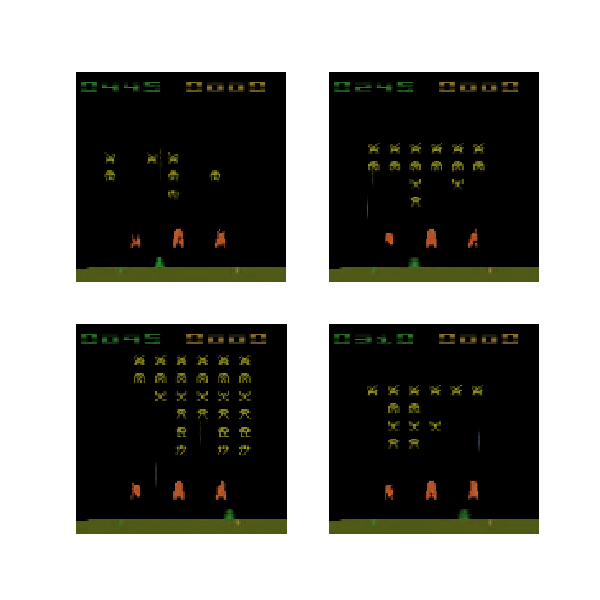

In [12]:
show_nums(results['R'][:4])

<IPython.core.display.Javascript object>


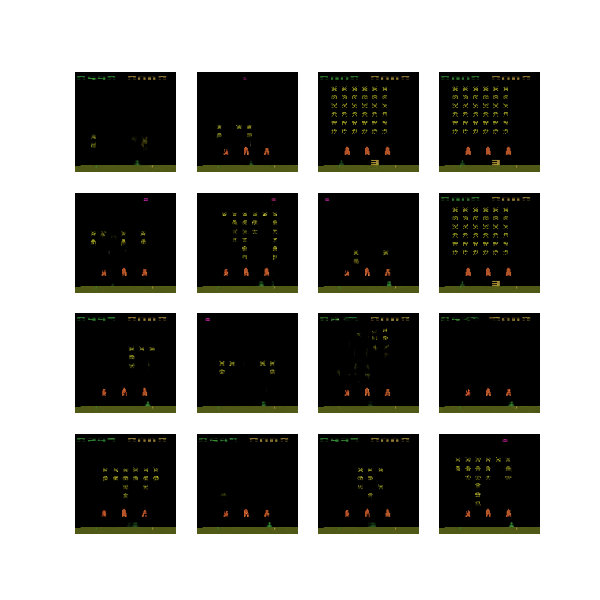

In [8]:
show_nums(results['H'][:16])

In [26]:
run.reset()

tdict(ckpt_path)

In [27]:
# print(run.state.model)

In [28]:
# S.keys()

In [29]:
# S.hello = 'world'

In [30]:
# update_checkpoint(S, 'hello')

In [31]:
# viz_

In [32]:
# S.fid_gen_stats.keys()

In [33]:
# update_checkpoint(S, 'fid_gen_stats', overwrite=True)

In [34]:
# import pickle

In [35]:
# path = os.path.join(os.environ["FOUNDATION_DATA_DIR"], '3dshapes', '3dshapes_stats_fid.pkl')
# f = pickle.load(open(path,'rb'))

In [36]:
# f

In [37]:
# run.state.keys()

In [38]:
# model = run.state.model

In [39]:
# q = run.state.q
# q.shape

In [40]:
# with torch.no_grad():
#     imgs = model.decode(q.div(100))
# imgs.shape

In [41]:
# show_nums(imgs)

In [42]:
# media_root = '/is/ei/fleeb/workspace/media/hybrid/gans/'
# run.save(media_root, overwrite=True)